In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import random
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
GOOGLE_COLAB = True

In [0]:
import sys

if GOOGLE_COLAB:
    sys.path.append('drive/My Drive/yelp_sentiment_analysis')
else:
    sys.path.append('../')

from yelpsent import data
from yelpsent import features
from yelpsent import metrics
from yelpsent import visualization
from yelpsent import models

# Load Dataset

In [0]:
if GOOGLE_COLAB:
    data_train, data_test = data.load_dataset("drive/My Drive/yelp_sentiment_analysis/data/yelp_train_clean_nolemma.json",
                                              "drive/My Drive/yelp_sentiment_analysis/data/yelp_test_clean_nolemma.json")
else:
    data_train, data_test = data.load_dataset("../data/yelp_train.json",
                                              "../data/yelp_test.json")

In [0]:
data_all = pd.concat([data_train, data_test])

In [10]:
data_train.head()

,review,sentiment
0,may 9 2015 party of six with reservations for ...,0
1,there was nothing good to say there i said it ...,0
2,went there with my friend ordered veal tartare...,0
3,service 2 5 waiter forgot drinks and did revis...,0
4,not great we were expecting a phenomenal burge...,0


In [11]:
data_train.describe()

,sentiment
count,135000.0000
mean,1.0000
std,0.8165
min,0.0000
25%,0.0000
50%,1.0000
75%,2.0000
max,2.0000


In [12]:
data_test.head()

,review,sentiment
0,this was probably the worst pho experience i v...,0
1,it s excellent just go we went there for a sec...,2
2,i love ethiopian food i love the injera and th...,2
3,we love the downtown location we visit it ever...,2
4,we to jamie s with some friends and i would gi...,2


In [13]:
data_test.describe()

,sentiment
count,90639.00000
mean,1.42421
std,0.80064
min,0.00000
25%,1.00000
50%,2.00000
75%,2.00000
max,2.00000


# Distribution

## Sentiment

In [14]:
pd.DataFrame(data_train.groupby('sentiment')['review'].count())

,review
sentiment,
0,45000
1,45000
2,45000


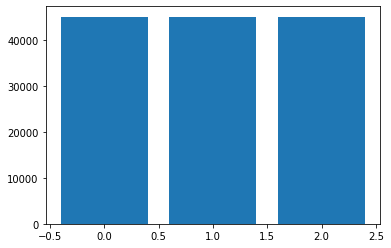

In [15]:
# Training
sentiment_dist_train = pd.DataFrame(data_train.groupby('sentiment')['review'].count())
plt.bar(sentiment_dist_train.index, sentiment_dist_train['review'])
plt.show()

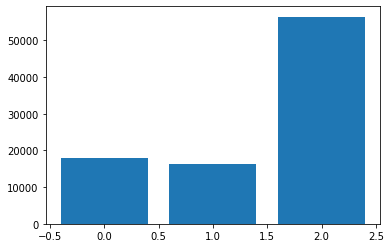

In [16]:
# Testing
sentiment_dist_test = pd.DataFrame(data_test.groupby('sentiment')['review'].count())
plt.bar(sentiment_dist_test.index, sentiment_dist_test['review'])
plt.show()

## Review Length

In [0]:
data_all['review_length'] = data_all['review'].apply(lambda x : len(x.split(' ')))

In [0]:
data_train['review_length'] = data_train['review'].apply(lambda x : len(x.split(' ')))

In [0]:
data_test['review_length'] = data_test['review'].apply(lambda x : len(x.split(' ')))

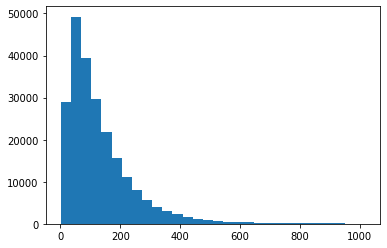

In [31]:
# All
plt.hist(data_all['review_length'], bins=30)
plt.show()

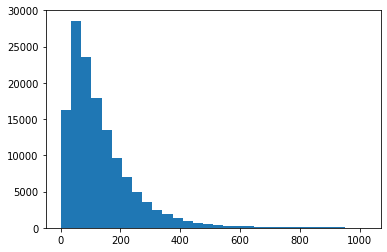

In [19]:
# Training
plt.hist(data_train['review_length'], bins=30)
plt.show()

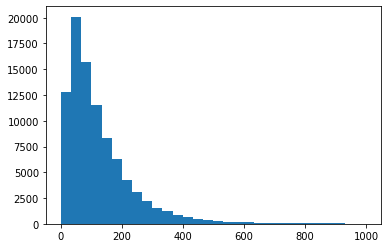

In [20]:
# Testing
plt.hist(data_test['review_length'], bins=30)
plt.show()

In [32]:
data_all.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,sentiment,review_length
count,225639.000000,225639.000000
mean,1.170405,130.402874
std,0.836430,113.647839
min,0.000000,1.000000
25%,0.000000,53.000000
50%,1.000000,98.000000
75%,2.000000,171.000000
90%,2.000000,269.000000
95%,2.000000,348.000000
99%,2.000000,564.000000


In [21]:
data_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,sentiment,review_length
count,135000.0000,135000.000000
mean,1.0000,133.612726
std,0.8165,115.091892
min,0.0000,1.000000
25%,0.0000,55.000000
50%,1.0000,101.000000
75%,2.0000,175.000000
90%,2.0000,273.000000
95%,2.0000,354.000000
99%,2.0000,572.000000


In [22]:
data_test.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,sentiment,review_length
count,90639.00000,90639.000000
mean,1.42421,125.622039
std,0.80064,111.291483
min,0.00000,1.000000
25%,1.00000,50.000000
50%,2.00000,93.000000
75%,2.00000,164.000000
90%,2.00000,261.000000
95%,2.00000,340.000000
99%,2.00000,549.000000


In [23]:
np.median(data_train['review_length'])

101.0

In [24]:
np.median(data_test['review_length'])

93.0

In [33]:
threshold = 200
print("Threshold: {0}".format(threshold))

print("All: {le}, {ht}".format(le=np.sum(data_all['review_length'] <= threshold),
                               ht=np.sum(data_all['review_length'] > threshold)))

print("Training: {le}, {ht}".format(le=np.sum(data_train['review_length'] <= threshold),
                                    ht=np.sum(data_train['review_length'] > threshold)))

print("Testing: {le}, {ht}".format(le=np.sum(data_test['review_length'] <= threshold),
                                   ht=np.sum(data_test['review_length'] > threshold)))

Threshold: 200
All: 183121, 42518
Training: 108434, 26566
Testing: 74687, 15952


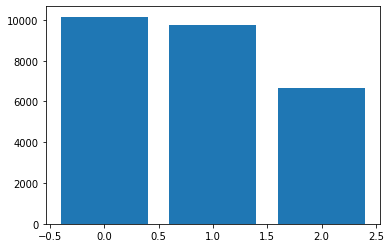

In [34]:
# Training, above threshold
sentiment_dist_train = pd.DataFrame(data_train.loc[data_train['review_length'] > threshold]
                                    .groupby('sentiment')['review'].count())
plt.bar(sentiment_dist_train.index, sentiment_dist_train['review'])
plt.show()

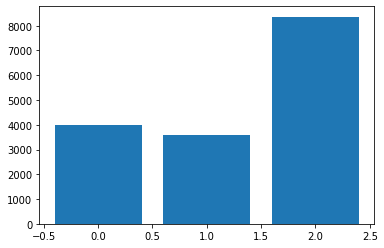

In [35]:
# Testing, above threshold
sentiment_dist_test = pd.DataFrame(data_test.loc[data_test['review_length'] > threshold]
                                    .groupby('sentiment')['review'].count())
plt.bar(sentiment_dist_test.index, sentiment_dist_test['review'])
plt.show()

In [38]:
data_train.loc[data_train['review_length'] > threshold].groupby('sentiment')['review'].count()

sentiment
0    10155
1     9773
2     6638
Name: review, dtype: int64

In [39]:
data_train.groupby('sentiment')['review'].count()

sentiment
0    45000
1    45000
2    45000
Name: review, dtype: int64